## Data Preparation
Pada tahap data preparation ini dilakukan proses pembersihan data supaya bisa lanjut ke tahap analisis data. Berikut tahapan-tahapan dalam melakukan pra-pemrosesan data:

- **Melakukan Casefolding**
  
   Pada tahap ini kita melakukan pembersihan kata-kata dimana hanya menyisakan kata-kata dengan alfabet kecil, artinya semua angka, tanda baca, huruf besar, alamat situs, dsb diganti/dihilangkan.


- **Melakukan Tokenizing Kalimat**

  Pada tahap ini dilakukan teknik pemisahan sebuah kalimat menjadi kata per kata yang biasa disebut token.


- **Melakukan Stopwords**

  Pada tahap ini kita menghilangkan kata-kata yang tidak terpakai atau banyak digunakan dari kalimat (stopword). Kata tersebut bisa kata sambung atau kata ganti orang, contohnya

- **Menghilangkan Kata Slang**

  Slang adalah bahasa gaul yang biasa disingkat atau tidak sesuai EYD. Pada tahap ini kita akan mengganti kata slang atau bahkan menghilangkan kata slang yang tidak berguna dalam analisis data kita.



In [1]:
#import semua library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk, string
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from numpy import array
import numpy as np
import tqdm


In [2]:
#Membaca data csv
df = pd.read_csv('indomie_tweet_search.csv')
df.head()

,title
0,@pieipa Indomie gorong boleh tu
1,Udah mau ngemil telur rebus ditaburi bumbu ind...
2,@IndomieGenerasi Trimakasih generasi indomie.....
3,Kalau masak indomie kuah selalu pake daun jeru...
4,"@Alamandapusp Kan selera dia indomie, tapi say..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [4]:
#membuat class dan fungsi untuk membersihkan data
class preprocessing:

  def caseFolding(self, data):
    data = data.lower()
    data = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", data).split())
    data = re.sub(r"\d+", "", data)
    data = data.translate(str.maketrans("", "", string.punctuation))
    data = re.sub(r"\n", "", data)
    return data

  def tokenizing(self, data):
    data = word_tokenize(data)
    return data

  def clear_stopwords(self, data):
    indonesia_s = stopwords.words('indonesian')
    indonesia_s = ["dan", "akan", "tetapi", "tidak"]
    negasi = ["tidak"]
    indonesia_s = [word for word in indonesia_s if word not in negasi]
    data = [word for word in data if word not in indonesia_s]
    data = ' '.join(data)
    return data
  
  def slang_cleaner(self, data,  slangWord:list=[]):
    word_token = self.tokenizing(data)
    word_list = []

    for word in word_token:
      for slang in slangWord:
        if word.lower() in slang[0].lower():
          word = slang[1]
          break
      word_list.append(word)

    data = ' '.join(word_list)
    return data


pp = preprocessing()

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
#membuat list kata-kata slang
slangWord = [
             ("mah", ""),
             ("tuh", ""),
             ("wae", "saja"),
             ("gak", "tidak"),
             ("wkwk", "ketawa"),
             ("gk", "tidak"),
             ("kagak", "tidak"),
             ("enggak", "tidak"),
             ("jgn", "jangan"),
             ("jngn", "jangan"),
             ("ga", "tidak"),
             ("yg", "yang"),
             ("aja", "saja"),
             ("teu", "tidak"),
             ("tpi", "tapi"),
             ("knp", "keanapa"),
             ("bkn", "bukan"),
             ("klo", "kalo"),
             ("skrg", "sekarang"),
             ("sih", ""),
             ("hah", ""),
             ("knpa", "kenapa"),
             ("engga", "tidak"),
             ("lbh", "lebih"),
             ("ska", "suka"),
             ("enk", "enak"),
             ("bs", "bisa"),
             ("jht", "jahat"),
             ("bsa", "bisa"),
             ("trimakasih", "terima kasih"),
             ("makasih", "terima kasih"),
             ("bgt", "banget"),
             ("pgn", "pengen"),
             ("blm", "belum"),
             ("gue", "aku"),
             ("gua", "aku"),
             ("emng", "emang"),
             ("gada", "gaada"),
             ("gaada", "tidak ada"),
             ("pdhl", "padahal"),
             ("lu", "kamu"),
             ("lo", "kamu"),
             ("gw", "aku"),
             ("weh", ""),
             ("ena", "enak"),
             ("ena-ena", "enak-enak"),
             ("wes", "sudah"),
             ("mangan", "makan"),
             ("dr", "dari"),
             ("drtd", "daritadi"),
             ("saiki", "sekarang")
]
#membersihkan data tweet dan membuat kolom baru yang berisi data tweet bersih
df['title'] = df['title'].apply(lambda x: pp.caseFolding(x))
df['title_clean'] = df['title'].apply(lambda x:pp.slang_cleaner(x, slangWord))
df['title_clean'] = df['title_clean'].apply(lambda x: pp.tokenizing(x))
df['title_clean'] = df['title_clean'].apply(lambda x: pp.clear_stopwords(x))

df

,title,title_clean
0,indomie gorong boleh tu,indomie gorong boleh
1,udah mau ngemil telur rebus ditaburi bumbu ind...,udah mau ngemil telur rebus ditaburi bumbu ind...
2,trimakasih generasi indomie pokoknya indomie g...,terima kasih generasi indomie pokoknya indomie...
3,kalau masak indomie kuah selalu pake daun jeruk,kalau masak indomie kuah selalu pake daun jeruk
4,kan selera dia indomie tapi sayangnya aku sarimi,kan selera dia indomie tapi sayangnya aku sarimi
...,...,...
995,ayo abis ini edit wayv sama indomie biar jadi ...,ayo abis ini edit wayv sama indomie biar jadi ...
996,indomie keknyaa biar seleramu,indomie keknyaa biar seleramu
997,nasi indomie wkwk jgn next time aja ya,nasi indomie ketawa jangan next time saja ya
998,yoii ini mau makan indomie dua bungkus,yoii ini mau makan indomie dua bungkus


## Data Processing
Pada tahap ini kita akan melakukan analisis data yang sudah bersih dengan menggunakan sentiment analysis menggunakan model TF-IDF & SVM, topic modelling, dan lainnya.

In [7]:
!git clone https://github.com/indobenchmark/indonlu

fatal: destination path 'indonlu' already exists and is not an empty directory.


In [8]:
data_train = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t', names=["Teks", "Target"])
data_test = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv', sep='\t', names=["Teks", "Target"])
#mengambil 5 data teratas pada data train
data_train.head()

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [9]:
#membersihkan teks data train
data_train['Teks'] = data_train['Teks'].apply(lambda x: pp.caseFolding(x))
data_train['Teks'] = data_train['Teks'].apply(lambda x:pp.slang_cleaner(x, slangWord))
data_train['Teks'] = data_train['Teks'].apply(lambda x: pp.tokenizing(x))
data_train['Teks'] = data_train['Teks'].apply(lambda x: pp.clear_stopwords(x))
data_train

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus tidak mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatera bandung tem...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh jadi mahasiswa jangan sombong dong terima ...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai partai yang telah berkoalisi,neutral
10998,pagi pagi di tol pasteur sudah macet parah bik...,negative


In [10]:
#membersihkan teks data test
data_test['Teks'] = data_test['Teks'].apply(lambda x: pp.caseFolding(x))
data_test['Teks'] = data_test['Teks'].apply(lambda x:pp.slang_cleaner(x, slangWord))
data_test['Teks'] = data_test['Teks'].apply(lambda x: pp.tokenizing(x))
data_test['Teks'] = data_test['Teks'].apply(lambda x: pp.clear_stopwords(x))
data_test

,Teks,Target
0,meski masa kampanye sudah selesai bukan berati...,neutral
1,tidak enak,negative
2,restoran ini menawarkan makanan sunda kami mem...,positive
3,lokasi di alun alun masakan padang ini cukup t...,positive
4,betapa bejad kader gerindra yang anggota dprd ...,negative
...,...,...
1255,film tncfu tidak cocok untuk penonton yang tid...,negative
1256,indihome ini mahal loh bayar nya hanya penanga...,negative
1257,be de gea cowok cupu yang takut dengan pacar n...,negative
1258,valen yang sangat tidak berkualitas konentator...,negative


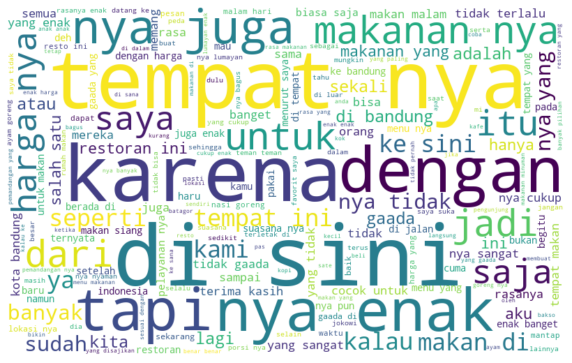

In [11]:
# Sentimen yang ada pada seluruh data train dapat dilihat dengan memahami kata yang umum dengan plot word cloud
 
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
 
all_words = ' '.join([text for text in data_train['Teks']])
wordCloud(all_words)

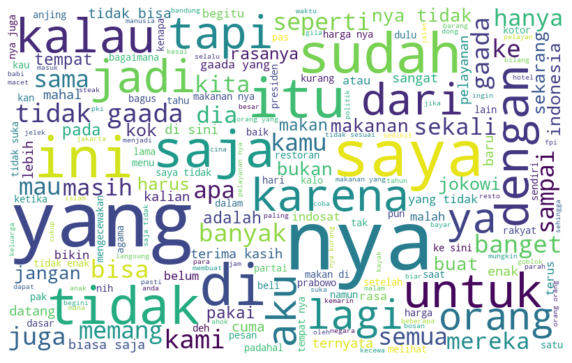

In [12]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'negative']) 
wordCloud(negative_words)

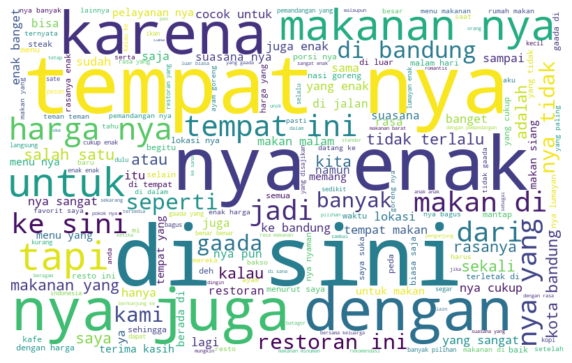

In [13]:
# Melihat kata-kata yang positif
positive_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'positive']) 
wordCloud(positive_words)

In [14]:
# Melakukan vektorisasi untuk mengekstrak fitur dengan TF-IDF
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
 
train_vectors = vectorizer.fit_transform(data_train['Teks'])
test_vectors = vectorizer.transform(data_test['Teks'])

In [15]:
# melakukan klasifikasi dengan SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, data_train['Target'])
prediction_linear = classifier_linear.predict(test_vectors)

In [16]:
# print metriks
target_names = ['positive', 'negative', 'netral']
print(classification_report(data_test['Target'], prediction_linear, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.81      0.85      0.83       394
    negative       0.83      0.71      0.77       131
      netral       0.92      0.91      0.91       735

    accuracy                           0.87      1260
   macro avg       0.85      0.83      0.84      1260
weighted avg       0.87      0.87      0.87      1260



In [17]:
teks_vector = vectorizer.transform(df['title_clean'])
df['sentimen'] = list(classifier_linear.predict(teks_vector))

df

,title,title_clean,sentimen
0,indomie gorong boleh tu,indomie gorong boleh,neutral
1,udah mau ngemil telur rebus ditaburi bumbu ind...,udah mau ngemil telur rebus ditaburi bumbu ind...,neutral
2,trimakasih generasi indomie pokoknya indomie g...,terima kasih generasi indomie pokoknya indomie...,positive
3,kalau masak indomie kuah selalu pake daun jeruk,kalau masak indomie kuah selalu pake daun jeruk,neutral
4,kan selera dia indomie tapi sayangnya aku sarimi,kan selera dia indomie tapi sayangnya aku sarimi,neutral
...,...,...,...
995,ayo abis ini edit wayv sama indomie biar jadi ...,ayo abis ini edit wayv sama indomie biar jadi ...,negative
996,indomie keknyaa biar seleramu,indomie keknyaa biar seleramu,neutral
997,nasi indomie wkwk jgn next time aja ya,nasi indomie ketawa jangan next time saja ya,negative
998,yoii ini mau makan indomie dua bungkus,yoii ini mau makan indomie dua bungkus,neutral


In [18]:
tweet_positif = [t for t in df['sentimen'] if t =="positive"]
tweet_negatif = [t for t in df['sentimen'] if t =="negative"]
tweet_netral = [t for t in df['sentimen'] if t =="neutral"]

In [19]:
print("Hasil Sentimen")
print("positif:", len(tweet_positif), "({} %)".format(100*len(tweet_positif)/len(df['sentimen'])))
print("negatif:", len(tweet_negatif),"({} %)".format(100*len(tweet_negatif)/len(df['sentimen'])))
print("netral:", len(tweet_netral), "({} %)".format(100*len(tweet_netral)/len(df['sentimen'])))

Hasil Sentimen
positif: 216 (21.6 %)
negatif: 184 (18.4 %)
netral: 600 (60.0 %)


#Analisa
Analisis sentiment menggunakan bantuan TD-IDF dan Support Vector Machine dimana data yang diuji dari library indoNLU. Dari hasil analisis dapat dilihat bahwa warga twitter kebanyakan memiliki sentimen netral tentang indomie. Tetapi sentimen positif lebih banyak dibandingkan sentimen negatif. Terdapat 216 tweet positif tentang indomie, 184 tweet negatif tentang indomie dan sisanya sebanyak 600 tweet netral terhadap porduk indomie. Dengan ini kita dapat menyimpulkan bahwa indomie tidak terlalu memiliki citra buruk di mata masyarakat kita.

# Topic Analysis
Pada bagian ini kita akan menganalisis topik pada data

In [20]:
data_title= [ title.split() for title in df["title_clean"]]
data_title

[['indomie', 'gorong', 'boleh'],
 ['udah',
  'mau',
  'ngemil',
  'telur',
  'rebus',
  'ditaburi',
  'bumbu',
  'indomie',
  'dulu',
  'sorry',
  'gapake',
  'mie',
  'ya'],
 ['terima',
  'kasih',
  'generasi',
  'indomie',
  'pokoknya',
  'indomie',
  'goreng',
  'adalah',
  'alternatif',
  'lain',
  'dikala',
  'bosen',
  'makanan'],
 ['kalau', 'masak', 'indomie', 'kuah', 'selalu', 'pake', 'daun', 'jeruk'],
 ['kan', 'selera', 'dia', 'indomie', 'tapi', 'sayangnya', 'aku', 'sarimi'],
 ['kak',
  'sayaka',
  'tidak',
  'suka',
  'seblak',
  'sukanya',
  'indomie',
  'sama',
  'malkist',
  'di',
  'saat',
  'duit',
  'lagi',
  'menipis',
  'ini',
  'semua',
  'asupannya',
  'anak',
  'kos',
  'tidak'],
 ['pagi',
  'sarapan',
  'indomie',
  'sambil',
  'nunggu',
  'yang',
  'jual',
  'gorengan',
  'lewat',
  'sehatnya',
  'sarapanku'],
 ['hujan', 'deras', 'pagi', 'hari', 'indomie', 'lapor', 'pak', 'terbaru'],
 ['kerja',
  'di',
  'tempat',
  'baru',
  'belajar',
  'lagi',
  'dari',
  'awa

In [21]:
dictionary = corpora.Dictionary(data_title)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_title]

#Membuat model
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )

#tampilkan data topik
from pprint import pprint
pprint(ldamodel.print_topics())
 

[(0,
  '0.126*"indomie" + 0.048*"goreng" + 0.024*"banget" + 0.023*"enak" + '
  '0.018*"tapi" + 0.017*"yang" + 0.017*"ya" + 0.015*"pengen" + 0.014*"telor" + '
  '0.013*"tidak"'),
 (1,
  '0.093*"indomie" + 0.024*"nasi" + 0.019*"jadi" + 0.016*"seblak" + '
  '0.014*"bakar" + 0.014*"bakso" + 0.013*"aku" + 0.013*"martabak" + '
  '0.013*"buat" + 0.012*"roti"'),
 (2,
  '0.068*"indomie" + 0.036*"makan" + 0.023*"kalo" + 0.017*"mau" + '
  '0.014*"bikin" + 0.013*"tapi" + 0.011*"tidak" + 0.010*"terima" + '
  '0.010*"kasih" + 0.010*"dari"'),
 (3,
  '0.061*"indomie" + 0.039*"aku" + 0.021*"saja" + 0.020*"tidak" + 0.017*"bisa" '
  '+ 0.016*"beli" + 0.014*"tapi" + 0.013*"yang" + 0.013*"di" + 0.013*"sama"'),
 (4,
  '0.092*"indomie" + 0.024*"mie" + 0.024*"tidak" + 0.021*"gaada" + '
  '0.021*"makan" + 0.019*"goreng" + 0.016*"pake" + 0.013*"kuah" + '
  '0.013*"masak" + 0.013*"yang"')]


##Analisa
Analisa dari topik diatas sebagai berikut:
1. Indomie goreng pakai telor rasanya enak
2. Makanan kesukaan seseorang
3. Bikin indomie untuk makan
4. Seseorang tidak bisa beli indomie
5. Masak indomie goreng pakai kuah



## Text Data Analysis
Pada bagian ini kita akan menganalisa jumlah karakter per tweet, kata per tweet, rata-rata panjang kata per tweet, dan bi-gram.

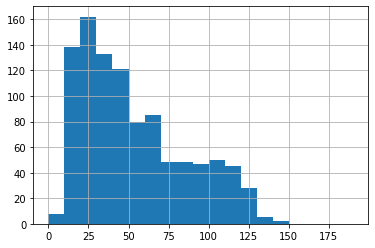

In [42]:
def charTweet(data):
  bin_range = np.arange(0, 200, 10)
  data.str.len().hist(bins=bin_range)
  plt.show()

charTweet(df['title_clean'])

Analisa:

Dari hasil grafik dapat dilihat bahwa jumlah distribusi karakter per tweet terbanyak berada di rentang 20 sampai 30 karater per tweetnya.

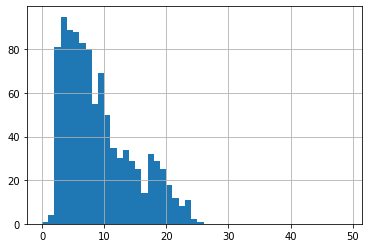

In [43]:
def wordTweet(data):
  bin_range = np.arange(0, 50)
  data.str.split().map(lambda x: len(x)).hist(bins=bin_range)
  plt.show()

wordTweet(df['title_clean'])

Analisa:

Dari hasil grafik dapat terlihat bahwa jumlah distribusi kata per tweet terbanyak berada di 5-8 kata per tweet.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


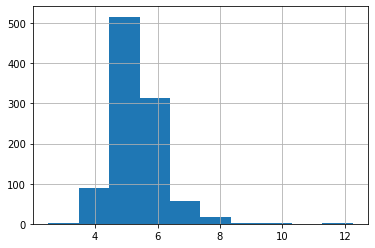

In [44]:
def longWord(data):
  data.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
  plt.show()

longWord(df['title_clean'])

Analisa:

Berdasarkan grafik diatas dapat dilihat bahwa jumlah distribusi rata-rata panjang per tweetnya terbanyak ada di 5-8 kata.

In [53]:
def mostCommonWord(data):
  data = data.apply(lambda x: word_tokenize(str(x)))
  tweets = [word for tweet in data for word in tweet]
  fqdist = FreqDist(tweets)
  most_common_word = fqdist.most_common(20)
  return most_common_word

mostCommonWord(df['title_clean'])

[('indomie', 976),
 ('tidak', 165),
 ('aku', 158),
 ('makan', 155),
 ('goreng', 149),
 ('tapi', 108),
 ('yang', 108),
 ('enak', 84),
 ('di', 79),
 ('mie', 75),
 ('banget', 75),
 ('saja', 70),
 ('ya', 69),
 ('masak', 69),
 ('kalo', 69),
 ('gaada', 64),
 ('pake', 59),
 ('kuah', 56),
 ('mau', 48),
 ('sama', 46)]

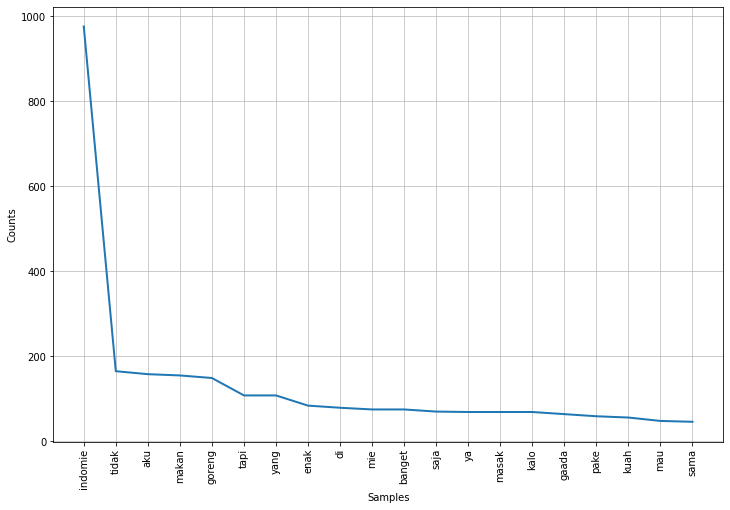

In [57]:
def fqdistPlot(data):
  data = data.apply(lambda x: word_tokenize(str(x)))
  tweets = [word for tweet in data for word in tweet]
  fqdist = FreqDist(tweets)
  plt.figure(figsize=(12,8))
  fqdist.plot(20,cumulative=False)
  plt.show()

fqdistPlot(df['title_clean'])

Analisa:

Dapat dilihat kata kunci indomie berada diurutan paling atas. Hal ini dikarenakan kata kunci yang kita gunakan adalah indomie. Lalu ada kata lainnya yang masih berkaitan dengan indomie seperti makan, goreng, masak, mie, dan lainnya.

In [56]:
def bigram(data):
  data = data.apply(lambda x: word_tokenize(str(x)))
  tweets = [word for tweet in data for word in tweet]
  result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
  print (result)

bigram(df['title_clean'])

(makan, indomie)       112
(indomie, goreng)      111
(masak, indomie)        52
(bikin, indomie)        33
(indomie, indomie)      32
(indomie, kuah)         30
(indomie, saja)         27
(jam, segini)           24
(pengen, indomie)       22
(indomie, tapi)         21
(indomie, seleraku)     20
(terima, kasih)         19
(indomie, tidak)        19
(gaada, indomie)        18
(bakso, martabak)       16
(roti, bakar)           16
(beli, indomie)         16
(indomie, bakso)        16
(indomie, rebus)        16
(bakar, batagor)        16
dtype: int64


Analisa:

Dari hasil bi-gram terlihat bahwa hampir seluruh tweet membahas tentang indomie dan makanan lainnya yang biasa dijual di warkop ataupun rotbak (roti bakar).

#Data Analysis

Berdasarkan model sentimen yang kita buat dapat dilihat bahwa indomie memiliki sentimen yang netral dari kalangan netizen twitter. Hal yang baik disini adalah netizen twitter lebih berpandangan positif tentang indomie dibandingkan negatif. SData tweet yang didapat juga masih menunjukan keterkaitan tentang indomie. 